In [1]:
%matplotlib inline

In [2]:
from KnackpackData import getEncoded,getScores,scoreFunction,n_items
import matplotlib.pyplot as plt
import numpy as np
import random
np.random.seed(seed=42)
random.seed(a=42)

## Initial population takes 20% of items

In [3]:
def initilization_of_population(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=np.bool_)
        chromosome[:int(0.8*n_feat)]=False
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return np.array(population)

## Fitness score by value of backpack

In [4]:
from numba import njit

@njit("float64[::1](boolean[:,::1],float64[::1],float64[::1],float64)")
def fitness_score(population,values,weights,max_weight_loc):
    return np.array([-1 if np.sum(weights[gene]) > max_weight_loc else np.sum(values[gene]) for gene in population])


## Roulette wheel selection

In [5]:
def selection(scores,population_nextgen,k,population_size):
    return random.choices(population_nextgen, weights = scores, k=population_size)

## Single point crossover

In [6]:
def crossover(pop_after_sel,crossover_rate):
    def crossingMethod(index):
        point = random.randint(0, len(pop_after_sel[0]))
        next_index = (index+1)%len(pop_after_sel)
        return np.concatenate((pop_after_sel[index][:point],pop_after_sel[next_index][point:]))
    childrens = np.array([crossingMethod(index) for index in range(len(pop_after_sel)) if random.random() < crossover_rate])
    return np.concatenate((pop_after_sel,childrens))

## Bit flip mutation

In [7]:
@njit("boolean[:,::1](boolean[:,::1],float64)")
def mutation(pop_after_cross,mutation_rate):
    size = pop_after_cross.shape[0]
    randoms = np.random.rand(size)
    unit_size = pop_after_cross.shape[1]
    for i in range(size):
        if(randoms[i]<mutation_rate):
            j = np.random.randint(0, unit_size)
            pop_after_cross[i][j]^=pop_after_cross[i][j]
    return pop_after_cross

## Generation loop with stop conditions:

* no change of best score through *max_stale_iterations*

*  90% of the population fall within convergence of the fittest individual

In [8]:
from math import isclose
def generations(values,weights,max_weight,population_size,n_feat,crossover_rate,mutation_rate,k_tournament,max_iteration,max_stale_iterations):
    def pupulation_in_convergence(scores,iteration_best_score):
        return sum(isclose(iteration_best_score,score) for score in scores)/scores.size>0.9
    alltime_best_score = 0
    stale_iteration = 0
    stop_reason = "Reached max_iteration!"
    # fittest does not change
    best_chromo= []
    best_score= []
    population_nextgen=initilization_of_population(population_size,n_feat)
    for i in range(max_iteration):
        scores = fitness_score(population_nextgen,values,weights,max_weight)

        bestIndex = np.argmax(scores)
        best_chromo.append(population_nextgen[bestIndex])
        best_score.append(scores[bestIndex])
        
        pop_after_sel = selection(scores,population_nextgen,k_tournament,population_size)
        pop_after_cross = crossover(pop_after_sel,crossover_rate)
        population_nextgen = mutation(pop_after_cross,mutation_rate)
        
        if alltime_best_score >= scores[bestIndex]:
            stale_iteration+=1
        else :
            stale_iteration=0
            alltime_best_score = scores[bestIndex]
        
        if stale_iteration>=max_stale_iterations:
            stop_reason = "Reached max_stale_iterations!"
            break
        if pupulation_in_convergence(scores,scores[bestIndex]):
            stop_reason = "Pupulation converge in 90%!"
            break
      
    return best_chromo,best_score,stop_reason

## Visualization methods

In [9]:
from operator import itemgetter
def plotScore(scores,bestindex):
    plt.figure(figsize=(8, 6), dpi=80) 
    plt.plot(scores)
    plt.scatter(bestindex, scores[bestindex],color="g",s=50)
    plt.annotate("best", (bestindex,scores[bestindex]))
    plt.ylabel('scores')
    plt.show()
    
def getBest(chromosomes,scores):
    best = max(zip(chromosomes,scores), key=itemgetter(1))
    bestindex = scores.index(best[1])
    return best,bestindex

In [10]:
from pandas import DataFrame, read_csv

max_weight = 3.0

correlation_levels = ["no", "low", "high"]
item_counts = list(range(16,25))
                  
results = np.zeros((len(item_counts), len(correlation_levels)))

for i, level in enumerate(correlation_levels):
    for j, item_count in enumerate(item_counts):
        csv = read_csv(f"data//{level}_correlation_{item_count}")
        n_items = csv.shape[0]
        values = csv.value.values
        weights = csv.weight.values

        chromo,score,stop_reason=generations(values,weights,max_weight,population_size=100,n_feat=n_items,crossover_rate=0.1,mutation_rate=0.3,k_tournament=0,max_iteration=100,max_stale_iterations=30)
        best,bestindex = getBest(chromo,score)

        results[j,i] = score[bestindex]
        print(f"Tests finished: {i*len(item_counts)+j+1}/{len(item_counts)*len(correlation_levels)}", end="\r")
        

In [11]:
df_res = DataFrame(data=results, columns=correlation_levels, index=item_counts)
df_res

,no,low,high
16,3.377188,3.692157,3.880483
17,3.782639,3.887430,4.551726
18,6.200920,5.990915,4.756207
19,4.696418,5.085308,4.943767
20,4.069551,4.221106,4.438831
21,5.961402,5.532199,4.787652
22,4.522730,5.057083,5.390234
23,5.637815,5.496954,4.955752
24,5.604005,5.407615,5.138602


<AxesSubplot:title={'center':'Result for correlated data'}, xlabel='Items', ylabel='Value'>

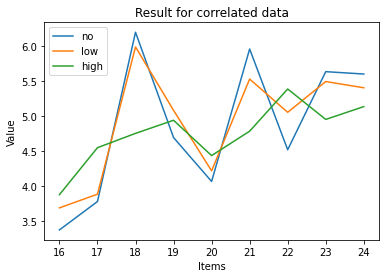

In [12]:
df_res.plot(title="Result for correlated data", xlabel="Items", ylabel="Value")

In [13]:
df_res.to_csv("Results\\GA.csv")

## K-Tournament Selection(20)

In [14]:
def selection(scores,population_nextgen,k,population_size):
    def tournament_selection(indices):
        return population_nextgen[max(indices,key=lambda index:scores[index])]
    return np.array([tournament_selection(random.choices(range(scores.size),k = k)) for _ in range(population_size)])

## Two point mutation

In [15]:
@njit("boolean[:,::1](boolean[:,::1],float64)")
def mutation(pop_after_cross,mutation_rate):
    size = pop_after_cross.shape[0]
    randoms = np.random.rand(size)
    unit_size = pop_after_cross.shape[1]
    for i in range(size):
        if(randoms[i]<mutation_rate):
            j = np.random.randint(0, unit_size)
            k = np.random.randint(0, unit_size)
            pop_after_cross[i][j]^=pop_after_cross[i][j]
            pop_after_cross[i][k]^=pop_after_cross[i][k]
    return pop_after_cross

## To use with SIMULATED ANNEALING ALGORITHM

In [16]:
class SimulatedAnnealing:
    def __init__(self, initial_temp = 1000, alpha = 0.999, frozen_level = 0.1, n_items = 16, values = [], weights = [], max_weight = 3):
        self.initial_temp = initial_temp
        self.alpha = alpha
        self.frozen_level = frozen_level
        self.n_items = n_items
        self.values = values
        self.weights = weights
        self.max_weight = max_weight
        self.min_weight = max_weight - 1
        
    def setInitialValues(self, initial_state = None):
        '''Wyzeruj tablice wyników oraz ustaw wartości początkowe.'''
        if initial_state is None:
            # Stan początkowy jest po prostu pustym plecakiem.
            self.initial_state = np.zeros(self.n_items).astype(bool)
        else:
            self.initial_state = initial_state
        self.best_state = self.initial_state
        self.current_state = self.initial_state
        
        self.temperature = self.initial_temp

        # Tablice wyników zawierają tylko zerowy stan.
        self.scores_table = [np.sum(self.values[self.initial_state])]
        self.best_scores_table = [np.sum(self.values[self.initial_state])]
        self.best_value_index = 0
    
    def run(self):
        if self.temperature is None:
            self.setInitialValues()
            
        it = 0
        while self.temperature > self.frozen_level:
            it += 1
            # Generate next state
            next_state = np.copy(self.current_state)
            next_state ^= np.array([np.random.uniform() < self.temperature/self.initial_temp for _ in range(self.n_items)])
            next_state = self.drop_or_add_items(next_state)
    
            self.scores_table.append(np.sum(self.values[next_state]))
            # Calculate delta (if next state is better than current)
            delta = np.sum(self.values[next_state]) - np.sum(self.values[self.current_state])

            if delta > 0:
                # If next state is better than current - set this state as current
                self.current_state = np.copy(next_state)

                # If new state is better than the best - set this state as best
                if self.fitness():
                    self.best_state = np.copy(self.current_state)
                    self.best_value_index = it
                    self.best_scores_table.append(np.sum(self.values[self.best_state]))
            else:
                # If the new solution is not better, accept it with a probability of e^(-delta/temp)
                acceptance_function = np.exp(-np.abs(delta)*10 / self.temperature)
                if acceptance_function > random.uniform(0, 1):
                    self.current_state = np.copy(next_state)

            self.temperature *= self.alpha
        
    def fitness(self):
        return np.sum(self.values[self.current_state]) > np.sum(self.values[self.best_state])
        
    def drop_or_add_items(self, next_state):
        while np.sum(self.weights[next_state]) < self.min_weight:
            idx = random.choice(np.where(next_state==False)[0])
            next_state[idx] = True
        
        while np.sum(self.weights[next_state]) > self.max_weight:
            idx = random.choice(np.where(next_state==True)[0])
            next_state[idx] = False
            
        return next_state
        
        
    def results(self):
        best_value = np.sum(self.values[self.best_state])
        best_weight = np.sum(self.weights[self.best_state])
#         print("Best value: ",best_value)
#         print("Best weight: ",best_weight)
#         print("Difference (value, weight):", getDiff(n_items,best_value, best_weight))
        return best_value

    def getBest(self):
        return self.best_state
        
    def plot_results(self, plot = 'best_of_all'):
        if plot == 'best_of_all':
            plt.figure(figsize=(16, 12), dpi=80)
            plt.scatter(self.best_value_index, np.array(self.scores_table)[self.best_value_index], color="r", s=200, zorder=2)
            plt.plot(np.arange(np.array(self.scores_table).size), np.array(self.scores_table), color="b", zorder=1)
            plt.title('Value changes')
        elif plot == 'best_changes':
            plt.figure(figsize=(16, 12), dpi=80)
            plt.plot(np.arange(np.array(self.best_scores_table).size), np.array(self.best_scores_table), color="b")
            plt.title('Best results changes')
            
        plt.ylabel('Value')
        plt.xlabel('Iteration')
        plt.show()

In [17]:
from math import isclose
def generations(values,weights,max_weight,population_size,n_feat,crossover_rate,mutation_rate,k_tournament,max_iteration,max_stale_iterations):
    def pupulation_in_convergence(scores,iteration_best_score):
        return sum(isclose(iteration_best_score,score) for score in scores)/scores.size>0.9
    alltime_best_score = 0
    stale_iteration = 0
    stop_reason = "Reached max_iteration!"
    # fittest does not change
    best_chromo= []
    best_score= []
    population_nextgen=initilization_of_population(population_size,n_feat)
    for i in range(max_iteration):
        scores = fitness_score(population_nextgen,values,weights,max_weight)
        bestIndex = np.argmax(scores)
        
        SA = SimulatedAnnealing(2100, 0.96, 0.0001, n_feat, values, weights, max_weight)
        SA.setInitialValues(population_nextgen[bestIndex])
        SA.run()
        population_nextgen[bestIndex] = SA.getBest()

        scores = fitness_score(population_nextgen,values,weights,max_weight)
        bestIndex = np.argmax(scores)

        best_chromo.append(population_nextgen[bestIndex])
        best_score.append(scores[bestIndex])
        
        pop_after_sel = selection(scores,population_nextgen,k_tournament,population_size)
        pop_after_cross = crossover(pop_after_sel,crossover_rate)
        population_nextgen = mutation(pop_after_cross,mutation_rate)
        
        if alltime_best_score >= scores[bestIndex]:
            stale_iteration+=1
        else :
            stale_iteration=0
            alltime_best_score = scores[bestIndex]
        
        if stale_iteration>=max_stale_iterations:
            stop_reason = "Reached max_stale_iterations!"
            break
        if pupulation_in_convergence(scores,scores[bestIndex]):
            stop_reason = "Pupulation converge in 90%!"
            break
  
    return best_chromo,best_score,stop_reason

Reached max_stale_iterations!


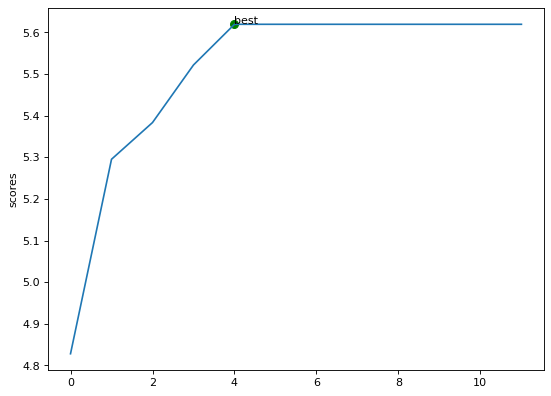

Final value[ True False  True False False  True False  True False  True False False
  True False  True  True False False  True False False  True False False]=-1.0


In [18]:
chromo,score,stop_reason=generations(values,weights,max_weight,population_size=100,n_feat=n_items,crossover_rate=0.8,mutation_rate=0.2,k_tournament=20,max_iteration=100,max_stale_iterations=7)
print(stop_reason)
best,bestindex = getBest(chromo,score)
plotScore(score,bestindex)
x = best[0]
y = scoreFunction(best[0])
print(f"Final value{x}={y}")

In [19]:
# from pandas import DataFrame, read_csv

max_weight = 3.0

correlation_levels = ["no", "low", "high"]
item_counts = list(range(16,25))
                  
results = np.zeros((len(item_counts), len(correlation_levels)))

for i, level in enumerate(correlation_levels):
    for j, item_count in enumerate(item_counts):
        csv = read_csv(f"data//{level}_correlation_{item_count}")
        n_items = csv.shape[0]
        values = csv.value.values
        weights = csv.weight.values

        chromo,score,stop_reason=generations(values,weights,max_weight,population_size=100,n_feat=n_items,crossover_rate=0.8,mutation_rate=0.2,k_tournament=20,max_iteration=100,max_stale_iterations=7)
        best,bestindex = getBest(chromo,score)

        results[j,i] = score[bestindex]
        print(f"Tests finished: {i*len(item_counts)+j+1}/{len(item_counts)*len(correlation_levels)}", end="\r")
        

In [20]:
df_res = DataFrame(data=results, columns=correlation_levels, index=item_counts)
df_res

,no,low,high
16,4.032696,4.404743,4.669439
17,4.684368,4.952518,5.128661
18,6.998610,7.673430,6.264490
19,5.429757,4.973490,5.452740
20,4.478135,5.106913,5.270496
21,5.633653,6.484294,5.668523
22,5.486530,5.818982,4.827094
23,6.108304,6.882207,6.118477
24,5.127226,5.425476,5.319302


<AxesSubplot:title={'center':'Result for correlated data'}, xlabel='Items', ylabel='Value'>

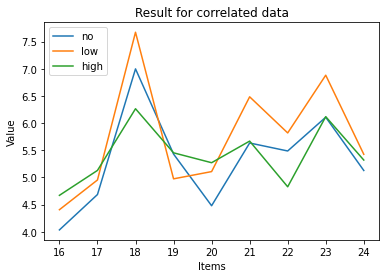

In [21]:
df_res.plot(title="Result for correlated data", xlabel="Items", ylabel="Value")

In [22]:
df_res.to_csv("Results\\SAGA.csv")

## Wynik 
Wynik to maksimum globalne